In [27]:
import numpy as np
import random as rd

import matplotlib.pyplot as plt
from matplotlib import lines
import seaborn as sns

import time

from numba import njit

## Support Functions

In [8]:
@njit
def sig(x: float, k: float) -> float: return (x > 0)*(x**2/(k**2 + x**2))

@njit
def IsPositive(x: float, l: float) -> float: return (x > l)

@njit
def DopamineReceptor(x: float, l: float, a: float = 10) -> float: return 1/(1 + np.exp(-a*(x - l)))

## Function for stimulus creation

In [13]:
# Main PPI model

@njit
def CreateStim(Hz: float, trial_type_list: tuple[str], stimuli_list: tuple[float], P: float, ISI: float, ITI_i: float, 
               ITI_f: float, d_PP: float, d_P: float) -> np.ndarray:
    """
    Create input stimulus to the cochlea unit in the PPI model.

    Parameters
    ----------
    Hz : float
        sample rate. The inverse of the integration time step dt

    trial_type_list : tuple[str]
        list with the trial types. Options are: "PP+P" and "P". If any other type is
        provided, it will be presented as a stimulus with intensity given in the 
        stimuli_list
    
    stimuli_list : tuple[float]
        prepulse intensity (in dB). Intensity considered as above a background of 60 dB. 
    
    P : float
        pulse intensity (in dB). Intensity considered as above a background of 60 dB. 
    
    ISI : int
        interstimulus interval (in ms). Interval between the prepulse and pulse presentations.
    ITI_i : float
        lower bound for the inter-trial interval (in ms)

    ITI_f : float
        upper bound for the inter-trial interval (in ms)

    d_PP : float
        prepulse duration (in ms)
    
    d_P : int
        pulse duration (in ms)

    Return
    ------
    stims : 1-D np.ndarray
        array representing the input to the cochlea (Ch unit)
    """

    rd.seed(1)
    ITI = np.random.uniform(ITI_i*1000, ITI_f*1000, size = len(trial_type_list))

    # all run simulate minimum 600 ms
    t_final = int(sum(ITI) + 600)
    n_points = Hz*t_final
    
    stims = np.zeros(n_points)
    
    # any stimulus starts only after 100 ms
    t_start = 100
    for i_iti, iti in enumerate(ITI):
        
        trial_type = trial_type_list[i_iti]
        intensity = stimuli_list[i_iti]
        
        # select trial type
        if trial_type == 'PP+P':
            t_end = t_start + d_PP
            stims[(t_start)*Hz:(t_end)*Hz] = intensity
            t_end = t_start + d_P
            stims[(t_start + ISI)*Hz:(t_end + ISI)*Hz] = P
        elif trial_type == 'P':
            t_end = t_start + d_P
            stims[(t_start + ISI)*Hz:(t_end + ISI)*Hz] = P
        else:
            t_end = t_start + d_P
            stims[(t_start)*Hz:(t_end)*Hz] = intensity
        
        t_start = t_end + int(iti)
    
    return stims

## Main PPI model function to run simulation

In [10]:
@njit
def ModelSession(Hz: float, stimuli: np.ndarray, n_seed: int = 159, DA_Amyg: tuple[float] = (0,0), DA_extra: float = 0,
                 DA_NAc: tuple[float] = (0,0), DA_mPFC: tuple[float] = (0,0), GABA_Amyg: float = 1, GABA_VP: float =1,
                 GABA_NAcI: float = 1, GABA_NAcD: float = 1, GABA_VTA: float = 1, GABA_mPFC: float = 1, 
                 GABA_mPFC_I: float = 1) -> tuple[np.ndarray]:
    """
    Simulate the PPI model. System of ODEs is integrated with the Euler method.

    Parameters
    ----------
    Hz : float
        inverse of the integration time step dt. Represents the sample rate.
        
    stimuli : numpy.array
        array representing the input to the cochlea (Ch unit)

    DA_Amyg : tuple(float)
        Simulate the effect of dopaminergic drugs in the amygdala. Firt term represents
        the D1 receptors and the second term the D2 receptors. Values in the tuple should
        be < 0 for antagonists and > 0 for agonists.

    DA_extra : float
    
    DA_NAc : tuple(float)
        Simulate the effect of dopaminergic drugs in the NAc. Firt term represents
        the D1 receptors and the second term the D2 receptors. Values in the tuple should
        be < 0 for antagonists and > 0 for agonists.
    
    DA_mPFC : tuple(float)
        Simulate the effect of dopaminergic drugs in the mPFC. Firt term represents
        the D1 receptors and the second term the D2 receptors. Values in the tuple should
        be < 0 for antagonists and > 0 for agonists.

    GABA_Amyg : float
        Simulate the effect of GABAergic drugs in the amygdala. For agonists GABA_Amyg < 1
        (reduce the activation of amygdala unit) and for antagonists GABA_Amyg > 1 (increase
        the activation of amygdala unit).
    
    GABA_VP : float
        Simulate the effect of GABAergic drugs in the VP. For agonists GABA_VP < 1
        (reduce the activation of VP unit) and for antagonists GABA_VP > 1 (increase
        the activation of VP unit).
    
    GABA_NAcI : float
        Simulate the effect of GABAergic drugs in the NAcI. For agonists GABA_NAcI < 1
        (reduce the activation of NAcI unit) and for antagonists GABA_NAcI > 1 (increase
        the activation of NAcI unit).
    
    GABA_NAcD : float
        Simulate the effect of GABAergic drugs in the NAcD. For agonists GABA_NAcD < 1
        (reduce the activation of NAcD unit) and for antagonists GABA_NAcD > 1 (increase
        the activation of NAcD unit).
    
    GABA_VTA : float
        Simulate the effect of GABAergic drugs in the VTA. For agonists GABA_VTA < 1
        (reduce the activation of VTA unit) and for antagonists GABA_VTA > 1 (increase
        the activation of VTA unit).

    GABA_mPFC : float
        Simulate the effect of GABAergic drugs in the excitatory mPFC subpopulation. 
        For agonists GABA_mPFC < 1 (reduce the activation of mPFC unit) and for 
        antagonists GABA_mPFC > 1 (increase the activation of mPFC unit).
    
    GABA_mPFC_I : float
        Simulate the effect of GABAergic drugs in the inhibitory mPFC subpopulation.
        For agonists GABA_mPFC_I < 1 (reduce the activation of mPFC_I unit) and for 
        antagonists GABA_mPFC_I > 1 (increase the activation of mPFC_I unit).
            
    Return
    ------
    A_Ch : 1-D np.ndarray
        Activity of the cochlea unit (Ch) in the ASR pathway.
    
    A_CRN : 1-D np.ndarray
        Activity of the cochlear root nucleus (CRN) in the ASR pathway.
    
    W : 1-D np.ndarray
        Connection strength between CRN and CPRN in the ASR pathway. Subjected to
        short-term depression.
    
    A_CPRN : 1-D np.ndarray
        Activity of the caudal pontine reticular nucleus (CPRN) in the ASR pathway.
    
    A_MN : 1-D np.ndarray
        Activity of the motor neurons (MN) in the ASR pathway.
    
    P_IC : 1-D np.ndarray
        Activity of the inferior colliculus (IC) in the PPI pathway.
    
    P_SC : 1-D np.ndarray
        Activity of the superior colliculus (IC) in the PPI pathway.
    
    P_PPT : 1-D np.ndarray
        Activity of the pedunculopontine tegmental nucleus (PPTg) in the PPI pathway.
    
    M_Amyg : 1-D np.ndarray
        Activity of the excitatory amygdala subpopulation (Amyg) in the modulatory pathway.
    
    M_Amyg_I : 1-D np.ndarray
        Activity of the inhibitory amygdala subpopulation (Amyg) in the modulatory pathway.
    
    M_NAcD : 1-D np.ndarray
        Activity of the direct nucleus accumbens pathway unit (NAcD) in the modulatory pathway.
    
    M_NAcI : 1-D np.ndarray
        Activity of the indirect nucleus accumbens pathway unit (NAcI) in the modulatory pathway.
    
    M_VP : 1-D np.ndarray
        Activity of the ventral pallidum (VP) in the modulatory pathway.

    M_VTA : 1-D np.ndarray
        Activity of the ventral tegmental area (VTA) in the modulatory pathway.
    
    M_mPFC : 1-D np.ndarray
        Activity of the excitatory prefrontal cortex subpopulation (M_mPFC) in the
        modulatory pathway.

    M_mPFC_I : 1-D np.ndarray
        Activity of the inhibitory prefrontal cortex subpopulation (M_mPFC) in the
        modulatory pathway.
    
    D_extraNAc : 1-D np.ndarray
        Dopamine concentration released by the tonic mechanism in the NAc in the 
        modulatory pathway.
    
    D_preNAc : 1-D np.ndarray
        Activity of the pre-synaptic dopamine receptors in the NAc in the modulatory pathway.
    
    D_pNAc : 1-D np.ndarray
        Dopamine concentration released by the phasic mechanism in the NAc in the 
        modulatory pathway.
    
    t : 1-D np.ndarray
        Time array
    
    I : 1-D np.ndarray
        Stimulus array
    """

    rd.seed(n_seed)
    
    # Temporal and integration parameters
    n_points = len(stimuli)
    dt = 1/Hz

    t = np.linspace(0, n_points/Hz, n_points)
    
    ### Initialize model arrays
    
    ## ASR Module
    A_Ch, A_CRN, A_CPRN, A_MN, W = np.zeros(n_points), np.zeros(n_points), np.zeros(n_points), np.zeros(n_points), np.ones(n_points)
    
    ## PPI Module
    P_IC, P_SC, P_PPT = np.zeros(n_points), np.zeros(n_points), np.zeros(n_points)
    
    ## Modulation Module
    M_NAcD, M_NAcI, M_Amyg = np.ones(n_points)*0.197, np.ones(n_points)*0.142, np.zeros(n_points)
    M_Amyg_I, M_mPFC_I = np.zeros(n_points), np.zeros(n_points)
    M_VP, M_mPFC, M_VTA = np.ones(n_points)*0.283, np.zeros(n_points), np.zeros(n_points)
    
    ## Dopaminergic Modulation
    D_extraNAc, D_preNAc, D_pNAc = np.ones(n_points)*0.243, np.ones(n_points)*0.361, np.zeros(n_points)

    ## Input array
    
    I = stimuli
    
    ######################
    ###   Parameters   ###
    ######################

    # Connection Strengths
    k_CRN = 0.1
    k_PPT = 0.3
    k_IC = 0.3
    k_SC = 0.3
    k_NAcI = 0.3
    k_NAcD = 0.3
    k_Amyg = 0.5
    k_VP = 0.3
    k_VTA = 0.5
    k_I = 35
    k_mPFC = 0.3
    k_lVTA = 0.1
    k_1p = 0.06
    k_D = 0.2
    k_DmPFC = 0.81
    d_max = 0.6
    
    # Thresholds
    l_init_CRN = 0.45
    l_W = 0.5
    l_NAcD = 0.7
    l_NAcI = 0.3
    l_Amyg = 0.45
    l_D2pre = 0.3
    l_D1pos = 0.5
    l_D2pos = 0.4
    

    # Tonic Activity 
    t_VP = 0.4
    t_mPFC = 0.3
    t_NAc = 0.2
    d_W = 90
    k_rand = 0.001
    
    # Time Constant
    tau_W = 15000
    tau = 10
    delay = 60
    tau_DA = 285
    tau_p = 5
    
    # Euler Method
    for i in range(n_points-1):
        
        j = (i-Hz*delay)*IsPositive(i-Hz*delay,0)
        
        # ASR Pathway
        A_Ch[i+1] = dt/tau*(-A_Ch[i] + sig(I[i],k_I)) + A_Ch[i] + rd.uniform(-k_rand,k_rand)
        A_CRN[i+1] = dt/tau*(-A_CRN[i] + A_Ch[i]) + A_CRN[i]
        
        W[i+1] = dt/tau_W*(-W[i]+1-d_W*IsPositive(A_CRN[i],l_W)*sig(A_CRN[i], k_CRN)) + W[i]
        l_CRN = l_init_CRN + k_lVTA*sig(M_VTA[i],k_VTA)
        A_CPRN[i+1] = dt/tau*(-A_CPRN[i] + W[i]*sig(A_CRN[i],k_CRN)*IsPositive(A_CRN[i],l_CRN)*(1-sig(P_PPT[i],k_PPT))) + A_CPRN[i]
        
        A_MN[i+1] = dt/tau*(-A_MN[i] + A_CPRN[i]) + A_MN[i]
        
        # PPI Pathway            
        P_IC[i+1] = dt/tau*(-P_IC[i] + sig(A_CRN[i],k_CRN)) + P_IC[i]
        P_SC[i+1] = dt/tau*(-P_SC[i] + sig(P_IC[i],k_IC)) + P_SC[i]
        P_PPT[i+1] = dt/tau*(-P_PPT[i] + sig(P_SC[j],k_SC)*(1-sig(M_VP[i],k_VP))*(1-sig(M_NAcD[i],k_NAcD))) + P_PPT[i]
        
        # Modulation Pathway

        D_1 = 1 + d_max*DopamineReceptor(M_VTA[i] + DA_Amyg[0],l_D1pos) 
        D_2 = 1 - d_max*DopamineReceptor(M_VTA[i] + DA_Amyg[1],l_D2pos) 
        M_Amyg_I[i+1] = dt/tau*(-M_Amyg_I[i] + GABA_Amyg*D_2*sig(M_mPFC[i],k_mPFC)) + M_Amyg_I[i]
        M_Amyg[i+1] = dt/tau*(-M_Amyg[i] + GABA_Amyg*sig(P_IC[j],k_IC)*D_1*(1-sig(D_2*M_Amyg_I[i],k_Amyg))) + M_Amyg[i]

        D_extraNAc[i+1] = dt/tau_DA*(-D_extraNAc[i] + DA_extra + k_DmPFC*t_mPFC + k_1p*D_pNAc[i]) + D_extraNAc[i]
        D_preNAc[i+1] = DopamineReceptor(D_extraNAc[i]+DA_NAc[1],l_D2pre)
        D_pNAc[i+1] = dt/tau_p*(-D_pNAc[i] + IsPositive(M_VTA[i],k_D*D_preNAc[i])*(M_VTA[i]-k_D*D_preNAc[i])) + D_pNAc[i]
        D_p = k_D*D_extraNAc[i] + D_pNAc[i]
        D_1 = 1 + d_max*DopamineReceptor(D_p+DA_NAc[0],l_D1pos) 
        D_2 = (1 - d_max*DopamineReceptor(D_p+DA_NAc[1],l_D2pos))*IsPositive(1 - d_max*DopamineReceptor(D_p+DA_NAc[1],l_D2pos),0)
        NAc_input = IsPositive(M_Amyg[i],l_NAcD)*(sig(M_Amyg[i],k_Amyg) + sig(M_mPFC[i],k_mPFC))
        M_NAcD[i+1] = dt/tau*(-M_NAcD[i] + GABA_NAcD*(NAc_input+t_NAc)*D_1*
                              (1 - sig(D_2*M_NAcI[i],k_NAcI))) + M_NAcD[i]
        NAc_input = IsPositive(M_Amyg[i],l_NAcI)*(sig(M_Amyg[i],k_Amyg) + sig(M_mPFC[i],k_mPFC))
        M_NAcI[i+1] = dt/tau*(-M_NAcI[i] + GABA_NAcI*(t_NAc+NAc_input)*D_2) + M_NAcI[i]

        M_VP[i+1] = dt/tau*(-M_VP[i] + GABA_VP*t_VP*(1-sig(D_2*M_NAcI[i], k_NAcI))) + M_VP[i]
        M_VTA[i+1] = dt/tau*(-M_VTA[i] + GABA_VTA*(1-sig(M_VP[i],k_VP))*(IsPositive(M_Amyg[i],l_Amyg)*sig(M_Amyg[i],k_Amyg) + sig(P_PPT[i],k_PPT))) + M_VTA[i]

        D_1 = 1 + d_max*DopamineReceptor(M_VTA[i]+DA_mPFC[0],l_D1pos) 
        D_2 = 1 - d_max*DopamineReceptor(M_VTA[i]+DA_mPFC[1],l_D2pos)
        M_mPFC_I[i+1] = dt/tau*(-M_mPFC_I[i] + GABA_mPFC_I*D_1*sig(M_Amyg[i],k_Amyg)) + M_mPFC_I[i]
        M_mPFC[i+1] = dt/tau*(-M_mPFC[i] + GABA_mPFC*((sig(P_IC[j],k_IC)+sig(M_Amyg[i],k_Amyg))*(1-D_2*sig(M_mPFC_I[i],k_mPFC)))) + M_mPFC[i]

    output = (A_Ch, A_CRN, W, A_CPRN, A_MN, P_IC, P_SC, P_PPT, M_Amyg, M_Amyg_I, M_NAcD, M_NAcI, M_VP, M_VTA, 
              M_mPFC, M_mPFC_I,D_extraNAc, D_preNAc, D_pNAc, t, I)
    
    return output

# Figure 1

In [11]:
start_time = time.time()

# Run prepulse + pulse trial
sequence_test = (('PP+P',),(25,))
sounds = CreateStim(Hz=50,trial_type_list=sequence_test[0], stimuli_list=sequence_test[1],
                    P=60,ISI=80,ITI_i=0,ITI_f=0,d_PP=30,d_P=30)
output = ModelSession(Hz=50, stimuli=sounds)

A_Ch, A_CRN, W, A_CPRN, A_MN, P_IC, P_SC, P_PPT, M_Amyg, M_Amyg_I, M_NAcD, M_NAcI, M_VP, M_VTA, M_mPFC,M_mPFC_I,D_extraNAc, D_preNAc, D_pNAc, t, I = output
PP = max(A_MN)


# Run pulse trial
sequence_test = (('P',),(60,))
sounds = CreateStim(Hz=50,trial_type_list=sequence_test[0], stimuli_list=sequence_test[1],
                    P=60,ISI=80,ITI_i=0,ITI_f=0,d_PP=30,d_P=30)
P = max(ModelSession(Hz=50,stimuli=sounds)[4])


# Calculate %PPI and print the motor neurons (A_MN) activity for the
# prepulse + pulse (PP) and pulse (P) trials
print(f'PPI = {(100*(P-PP)/P):.3f}')
print(f'PP = {PP:.3f} & P = {P:.3f}')

# Print the time took to run the simulation
print(f'--- {(time.time() - start_time):.3f} seconds ---')

PPI = 84.819
PP = 0.093 & P = 0.615
--- 3.509 seconds ---


Text(0.5, 0.04, 't (ms)')

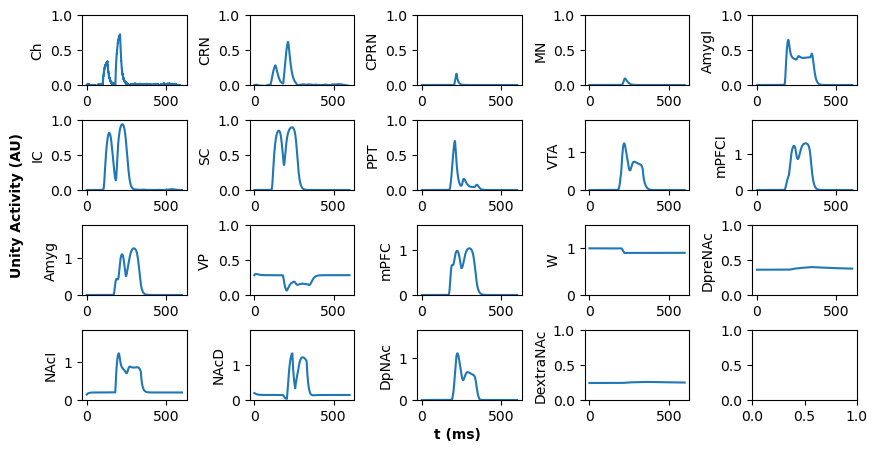

In [12]:
fig, ax = plt.subplots(4,5, figsize = (10,5), num=1)
fig.subplots_adjust(hspace= 0.5, wspace = 0.6)

Exp = [[A_Ch, A_CRN, A_CPRN, A_MN, M_Amyg_I],
       [P_IC, P_SC, P_PPT, M_VTA, M_mPFC_I],
       [M_Amyg, M_VP, M_mPFC, W, D_preNAc],
       [M_NAcI, M_NAcD, D_pNAc, D_extraNAc]]

Label = [['Ch', 'CRN', 'CPRN', 'MN', 'AmygI'],
         ['IC', 'SC', 'PPT', 'VTA', 'mPFCI'],
         ['Amyg', 'VP', 'mPFC', 'W', 'DpreNAc'], 
         ['NAcI', 'NAcD', 'DpNAc', 'DextraNAc']]

maximum = 1

for i in range(len(Exp)):
    for j in range(len(Exp[i])):
        ax[i,j].plot(t,Exp[i][j])
        ax[i,j].set_ylabel(Label[i][j])
        
        if max(Exp[i][j]) >= 1:
               maximum = 1.5*max(Exp[i][j])
                            
        ax[i,j].set_ylim(0, maximum)
        maximum = 1
        
fig.text(0.06,0.5,'Unity Activity (AU)', ha='center',va='center', rotation='vertical', fontweight='bold')
fig.text(0.5,0.04,'t (ms)', ha='center',va='center', fontweight='bold')

# Figure 2

In [18]:
## Get %PPI for control condition

start_time = time.time()

sequence_test = (('PP+P',), (25,))
sounds = CreateStim(Hz=50,trial_type_list=sequence_test[0], stimuli_list=sequence_test[1],
                    P=60,ISI=80,ITI_i=0,ITI_f=0,d_PP=30,d_P=30)
PP = max(ModelSession(Hz=50,stimuli=sounds)[4])

sequence_test = (('P',), (60,))
sounds = CreateStim(Hz=50,trial_type_list=sequence_test[0], stimuli_list=sequence_test[1],
                    P=60,ISI=80,ITI_i=0,ITI_f=0,d_PP=30,d_P=30)
P = max(ModelSession(Hz=50,stimuli=sounds)[4])

PPI_control = 100*(P-PP)/P
    
    
print(f'Control %PPI = {PPI_control:.3f}')
print(f'--- {(time.time() - start_time):.3f} seconds ---') 

Control %PPI = 84.819
--- 0.033 seconds ---


In [35]:
start_time = time.time()

n_GABA_points = 21
GABA = np.linspace(0,2,n_GABA_points)

PPI = np.zeros(shape = (n_GABA_points, n_GABA_points), dtype='float')

for i_Amyg, GABA_Amyg in enumerate(GABA):
    for i_VP, GABA_VP in enumerate(GABA):
        
        sequence_test = (('PP+P',), (25,))
        sounds = CreateStim(Hz=50,trial_type_list=sequence_test[0], stimuli_list=sequence_test[1],
                            P=60,ISI=80,ITI_i=0,ITI_f=0,d_PP=30,d_P=30)
        PP = max(ModelSession(Hz=50,stimuli=sounds, GABA_VP=GABA_VP,GABA_Amyg=GABA_Amyg)[4])

        sequence_test = (('P',), (60,))
        sounds = CreateStim(Hz=50,trial_type_list=sequence_test[0], stimuli_list=sequence_test[1],
                            P=60,ISI=80,ITI_i=0,ITI_f=0,d_PP=30,d_P=30)
        P = max(ModelSession(Hz=50,stimuli=sounds, GABA_VP=GABA_VP,GABA_Amyg=GABA_Amyg)[4])

        PPI[i_Amyg, i_VP] = 100*(P-PP)/P

print("--- %s seconds ---" % (time.time() - start_time))

--- 11.645073175430298 seconds ---


Text(0.79, 0.575, 'Difference in %PPI from Control')

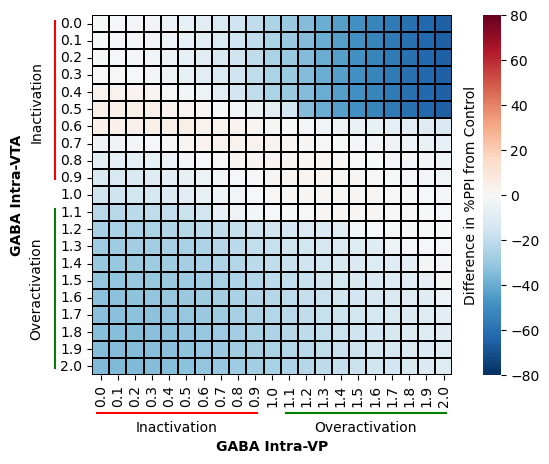

In [37]:
fig, ax = plt.subplots(num = 101, figsize=(6.4,4.8),dpi=100)
fig.subplots_adjust(0, 0.2, 0.95, 0.95)

### Plot data ###
heat = sns.heatmap(PPI-PPI_control, cmap="RdBu_r", square=True,linewidths=.1, linecolor='k', 
                   ax=ax,yticklabels = GABA, xticklabels = GABA, vmin=-80, vmax=80)

### Cosmetics ###

h1 = lines.Line2D([0.205, 0.455], [0.12, 0.12], color='r',transform=fig.transFigure, figure=fig)
h2 = lines.Line2D([0.5, 0.75], [0.12, 0.12], color='g',transform=fig.transFigure, figure=fig)
fig.text(0.33, 0.09, 'Inactivation', ha = 'center', va = 'center')
fig.text(0.625, 0.09, 'Overactivation', ha = 'center', va = 'center')
fig.text(0.478, 0.05, 'GABA Intra-VP', ha = 'center', va = 'center', weight='bold')

v1 = lines.Line2D([0.14, 0.14], [0.215, 0.545], color='g',transform=fig.transFigure, figure=fig)
v2 = lines.Line2D([0.14, 0.14], [0.608, 0.938], color='r',transform=fig.transFigure, figure=fig)
fig.text(0.11, 0.38, 'Overactivation', ha = 'center', va = 'center', rotation='vertical')
fig.text(0.11, 0.77, 'Inactivation', ha = 'center', va = 'center', rotation='vertical')
fig.text(0.08, 0.575, 'GABA Intra-VTA', ha = 'center', va = 'center', rotation='vertical', weight='bold')

fig.lines.extend([h1,h2,v1,v2])

# format ticks labels
ax.set_xticklabels([f'{gaba:.1f}' for gaba in GABA])
ax.set_yticklabels([f'{gaba:.1f}' for gaba in GABA])

# cbar label
fig.text(0.79, 0.575, 'Difference in %PPI from Control', ha = 'center', va = 'center', rotation='vertical')